# Feature Relation Graph

After obtaining masks with autmatic mask extraction script, we want to dig more features of the masks (and their underlying image) with the help of deep nerual network.  
In this notebook, we create a pipeline to:  
1. extract image sample of each mask  
2. extract features of each image sample with DNN  
3. compute feature distances between sample pairs  
4. create a feature relation graph using feature distance as graph edge  
5. find feature clusters from the feature relation graph  


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os
import pickle
import argparse
import itertools
from datetime import datetime
import gc

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.nn.init as init
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
from tqdm import tqdm
import multiprocessing as mp

from datasets.simple import *
from resnet import *
from transforms import *
from plot import *

In [2]:
data_root = '../../data/chromosome'

sample_path = os.path.join(data_root, 'raw/sample')
chunk_path = os.path.join(data_root, 'chunk')

if not os.path.exists(chunk_path):
    os.mkdir(chunk_path)

original_size = 1024

## 1. extract image sample of each mask
and save to files

In [3]:
raw_list = os.listdir(sample_path)
extractor = AutoMask()

def crop_file(extractor, raw_path, chunk_path, raw_filename):
    img = cv2.imread(os.path.join(raw_path, raw_filename))
    gray_img, indexes, contours = extractor.extract_masks(img)
    extractor.extract_chunks(gray_img, indexes, contours, chunk_path, raw_filename)
    

In [ ]:
pool = mp.Pool()
results = pool.starmap(crop_file, [((extractor, sample_path, chunk_path, raw_filename)) for raw_filename in raw_list])
print(len(results))

In [ ]:
# serial process, keep for debugging

with tqdm(total=len(raw_list), file=sys.stdout) as pbar:
    for raw_filename in raw_list:
        crop_file(extractor, sample_path, chunk_path, raw_filename)
        
        pbar.update(1)
        

In [4]:
# compute max w, h
chunk_path = '/media/ssd-ext4/chunk' # chunks should be in ssd, hdd will cause perf. problem

chunk_list = os.listdir(chunk_path)

ws = []
hs = []

def get_chunk_shape(chunk_file):
    chunk_img = cv2.imread(chunk_file)
    chunk_img = cv2.cvtColor(chunk_img, cv2.COLOR_BGR2GRAY)
    chunk_shape = chunk_img.shape
    
    return chunk_shape

chunk_files = [os.path.join(chunk_path, chunk_filename) for chunk_filename in chunk_list]

pool = mp.Pool()
shapes = list(tqdm(pool.imap_unordered(get_chunk_shape, chunk_files), total=len(chunk_files), file=sys.stdout))


100%|██████████| 3036708/3036708 [01:33<00:00, 32324.67it/s]


In [7]:
ws = []
hs = []

for s in shapes:
    h, w = s
    ws.append(w)
    hs.append(h)
    
print('max w: {}, max h: {}'.format(np.max(ws), np.max(hs)))
print('mean w: {}, mean h: {}'.format(np.mean(ws), np.mean(hs)))
print('std w: {}, std h: {}'.format(np.std(ws), np.std(hs)))

max w: 798, max h: 1012
mean w: 54.0325740901002, mean h: 53.73385916591256
std w: 34.90611805773713, std h: 35.248473840910194


## 2. extract features of each image sample with DNN

In [16]:
batch_size = 1280
target_size = 256
chunk_path = '/media/ssd-ext4/chunk' # chunks should be in ssd, hdd will cause perf. problem

In [17]:
# prepare network

net = models.resnet34(pretrained=True, progress=True).cuda()
net = nn.DataParallel(net)
net.eval()


DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [18]:
# simple dataset

class ChunkDataset(Dataset):
    def __init__(
        self,
        data_root,
        transform=None
    ):
        self.data_root = data_root
        self.transform = transform
        
        chunk_names = os.listdir(self.data_root)
        self.chunk_list = []
        for chunk_name in chunk_names:
            self.chunk_list.append(os.path.join(self.data_root, chunk_name))
        
        self.total_len = len(self.chunk_list)
        
    def __len__(self):
        return self.total_len
    
    def __getitem__(self, index):
        img = Image.open(self.chunk_list[index])
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img

transform = transforms.Compose([
    Scale(target_size / 2),
    Square(target_size),
    AutoLevel(0.7, 0.0001),
    transforms.ToTensor(),
    ChannelExpand()
])

chunk_dataset = ChunkDataset(chunk_path, transform=transform)

loader = DataLoader(
    chunk_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8
)

In [6]:
# forward

all_logits = []

with torch.no_grad():
    with tqdm(total=len(loader), file=sys.stdout) as pbar:
        for imgs in loader:
            imgs = imgs.cuda()

            logits = net(imgs)

            logits = logits.detach().cpu()
            all_logits.append(logits)
            
            pbar.update(1)


100%|██████████| 2373/2373 [42:04<00:00,  1.15it/s]


In [16]:
now = datetime.now()
torch.save(all_logits, 'metric_{}_{}_{}.pth'.format(now.strftime('%Y%m%d-%H%M%S'), chunk_dataset.total_len, target_size))


## 3. calc metric

Let's first try cosine metric.  

In [3]:
metric_filename = 'metric_20190925-142840_3036708_256.pth'
all_logits = torch.load(metric_filename)

In [4]:
all_logits = torch.cat(all_logits)
print(all_logits.shape)

all_embeddings = F.softmax(all_logits, dim=-1)


torch.Size([3036708, 1000])


In [80]:
# let's use only a small part of embeddings for experiments
embeddings = all_embeddings[:5000, :]
print(embeddings.shape)


torch.Size([5000, 1000])


In [22]:
def parallel_cosine_similarity(a, b):
    a_norm = a / a.norm(dim=-1)[:, None]
    b_norm = b / b.norm(dim=-1)[:, None]
    
    cos = torch.mm(a_norm, b_norm.transpose(0, 1))
    return cos


In [23]:
embeddings = embeddings.cuda()
dists = []

with tqdm(total=embeddings.shape[0], file=sys.stdout) as pbar:
    for i in range(embeddings.shape[0]):
        dists.append(parallel_cosine_similarity(embeddings[i].unsqueeze(0), embeddings).cpu())
        pbar.update(1)

print(len(dists))

100%|██████████| 100/100 [00:00<00:00, 8210.12it/s]
100


In [24]:
now = datetime.now()
torch.save(dists, 'distance_{}_{}.pth'.format(now.strftime('%Y%m%d-%H%M%S'), len(dists)))

In [25]:
del all_logits, all_embeddings, embeddings, dists

gc.collect()
torch.cuda.empty_cache()

## 4. create graph

Let's create a graph with networkx...

In [90]:
dist_filename = 'distance_20190925-165742_5000.pth'
dists = torch.load(dist_filename)

In [91]:
with tqdm(total=len(dists), file=sys.stdout) as pbar:
    for i in range(len(dists)):
        dists[i] = 1 - dists[i]
        
        pbar.update(1)

100%|██████████| 5000/5000 [00:00<00:00, 100104.15it/s]


In [69]:
# create graph by adding edges

import networkx as nx

G = nx.Graph()

with tqdm(total=len(dists), file=sys.stdout) as pbar:
    for i, dts in enumerate(dists):
        dts = dts.numpy().squeeze().tolist()

        for j, dist in enumerate(dts):
            G.add_edge(i, j, weight=dist)
        
        pbar.update(1)

100%|██████████| 100/100 [00:00<00:00, 12662.43it/s]


In [70]:
print('nodes: {}, edges: {}'.format(G.number_of_nodes(), G.number_of_edges()))


nodes: 100, edges: 5050


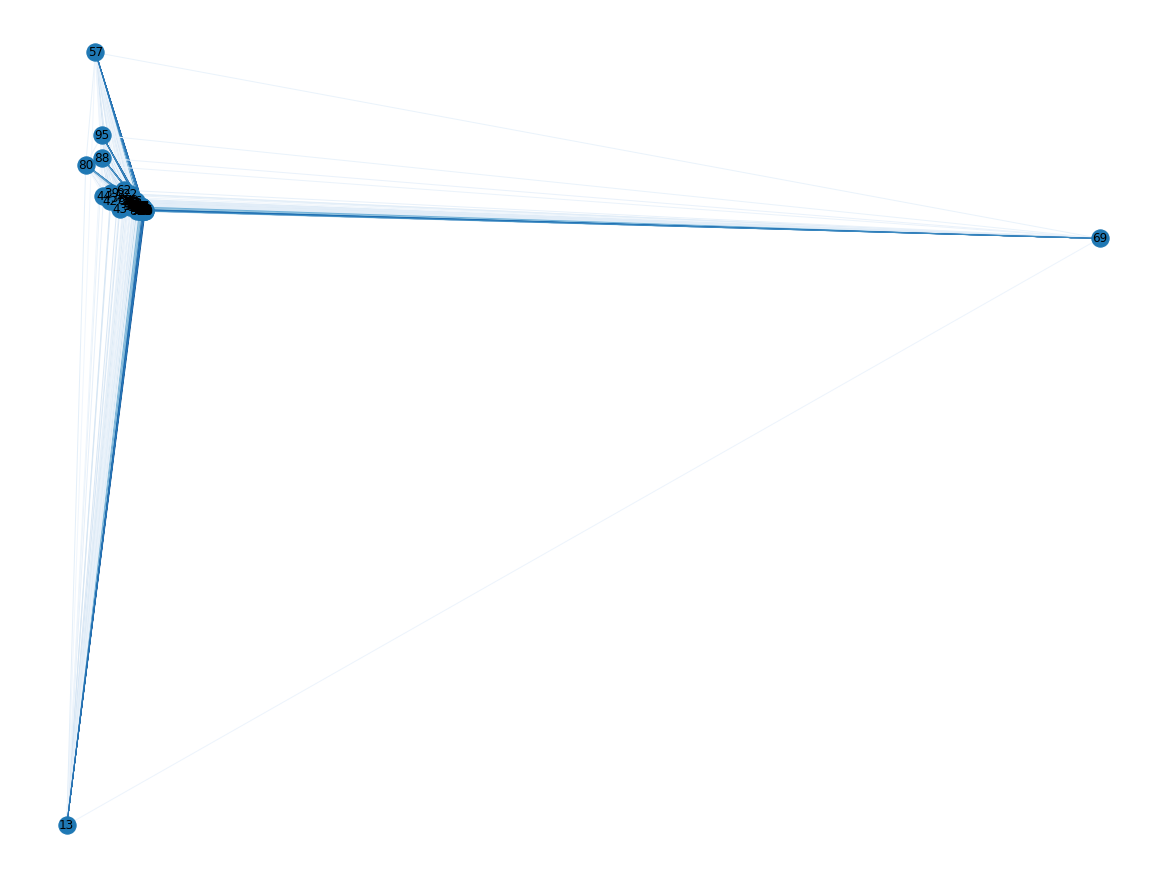

In [71]:
edges = nx.to_edgelist(G)
edge_colors = []

for edge in edges:
    edge_colors.append(edge[2]['weight'])

fig=plt.figure(figsize=(16,12))
nx.draw_spectral(G, with_labels=True, cmap=plt.cm.Blues, edge_color=edge_colors, edge_cmap=plt.cm.Blues)

### let's show roi

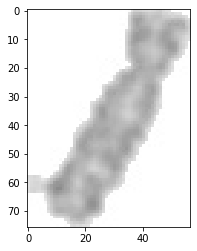

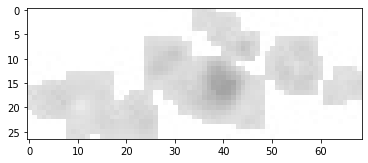

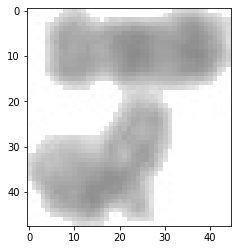

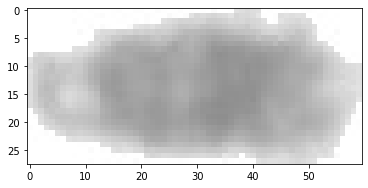

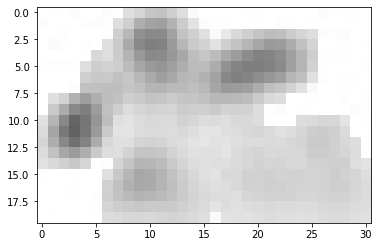

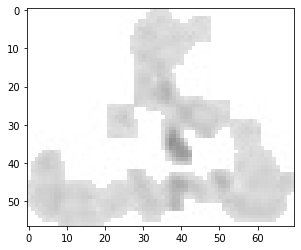

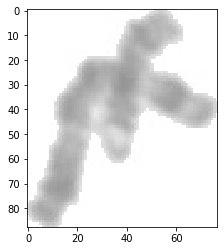

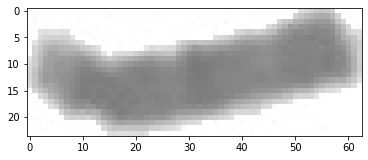

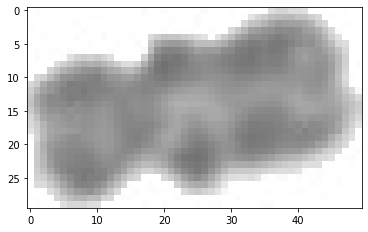

In [73]:
#rois = [2118, 1618]
rois = [13, 69, 57, 80, 88, 95, 1, 2, 3]
roi_files = [chunk_dataset.chunk_list[roi] for roi in rois]

for roi_file in roi_files:
    roi_img = cv2.imread(roi_file)
    
    #fig=plt.figure(figsize=(16,12))
    plt.imshow(roi_img)
    plt.show()

## 5. clustering

now, let's try something else: t-SNE

In [5]:
from sklearn.manifold import TSNE

def draw_tsne(embed):
    x, y = embed.transpose()

    fig=plt.figure(figsize=(16,12))
    plt.scatter(x, y)
    plt.show()


In [138]:
embeddings_euclid = TSNE(n_components=2).fit_transform(embeddings)

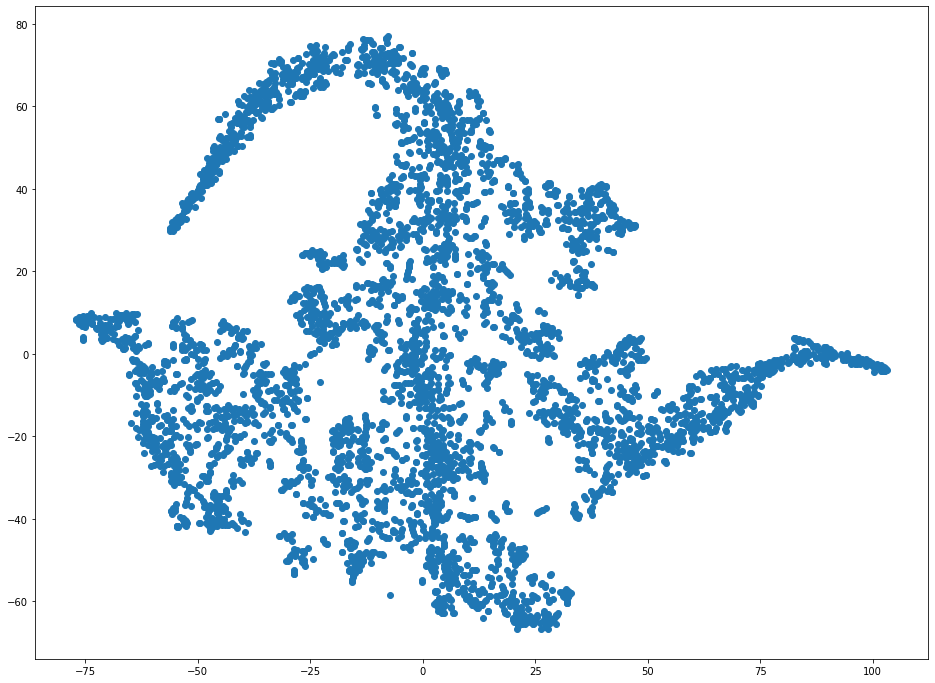

In [139]:
draw_tsne(embeddings_euclid)

t-SNE with cosine metric applied

In [ ]:
embeddings_cosine = TSNE(n_components=2).fit_transform(torch.cat(dists))

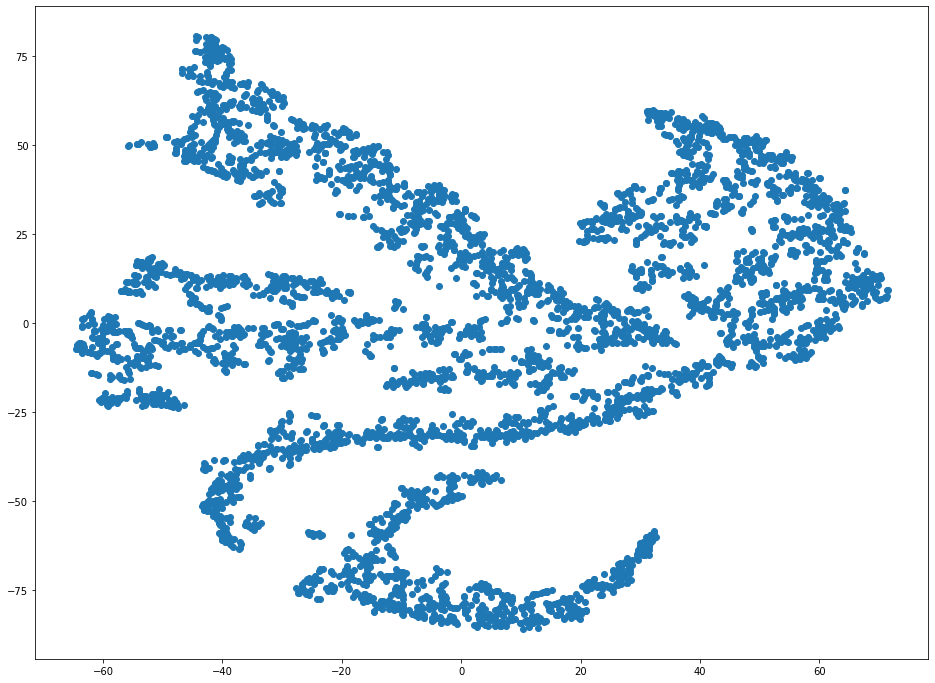

In [361]:
draw_tsne(embeddings_cosine)

there should be some kind of clustering pattern  
let's try bayesian-GMM:

In [347]:
from sklearn import mixture

cluster_num = 5

def draw_clusters(clusters, cluster_num, embeddings, colors):
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(1, 1, 1)

    for g, c in zip(range(cluster_num), colors):
        condlist = clusters == g
        cluster = np.compress(condlist, embeddings, axis=0)

        x, y = cluster.transpose()

        ax.scatter(x, y, c=c)

    plt.show()


In [351]:
clusters_bgmm = mixture.BayesianGaussianMixture(n_components=cluster_num, covariance_type='full').fit_predict(embeddings)

/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


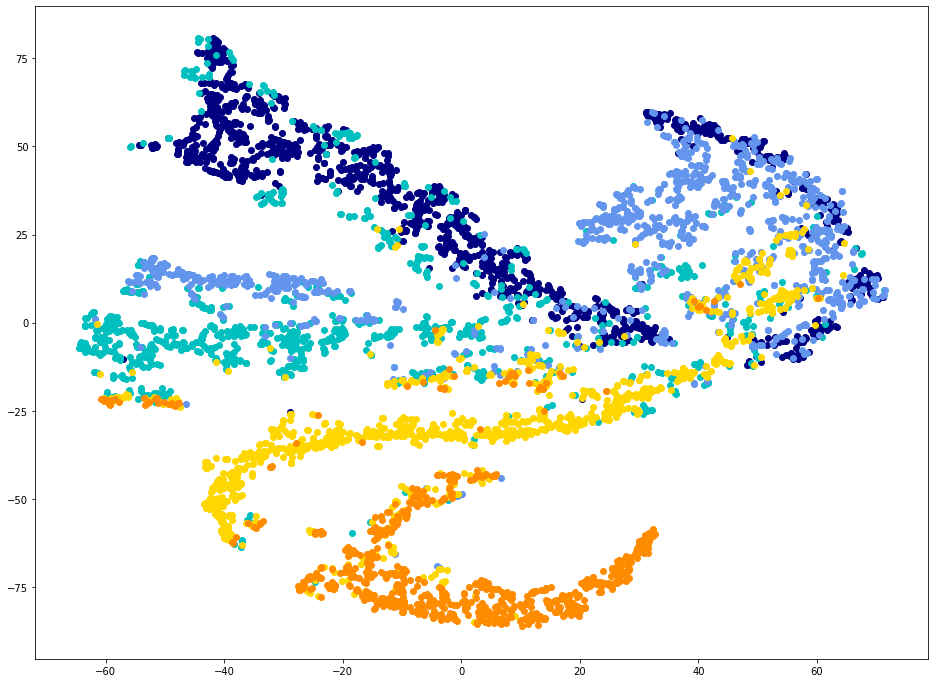

In [352]:
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold', 'darkorange'])

draw_clusters(clusters_bgmm, cluster_num, embeddings_cosine, color_iter)


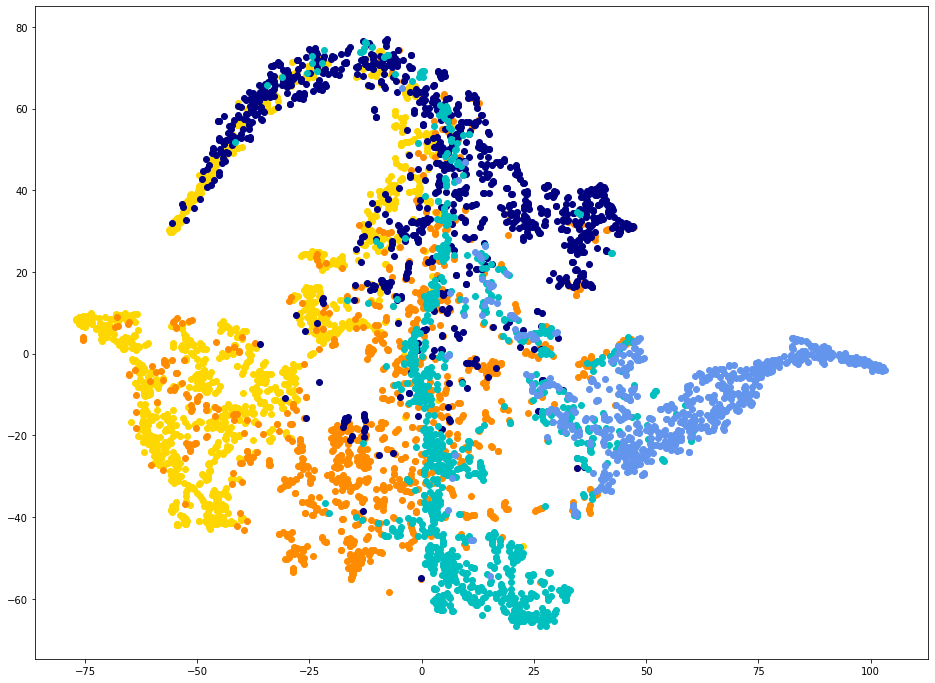

In [362]:
draw_clusters(clusters_bgmm, cluster_num, embeddings_euclid, color_iter)

try SpectralClustering

In [208]:
from sklearn.cluster import SpectralClustering

cluster_num = 5

In [209]:
clusters_spectral = SpectralClustering(n_clusters=cluster_num, affinity='cosine', assign_labels="discretize", random_state=0).fit_predict(embeddings)

In [210]:
print(clusters_spectral.shape)

(5000,)


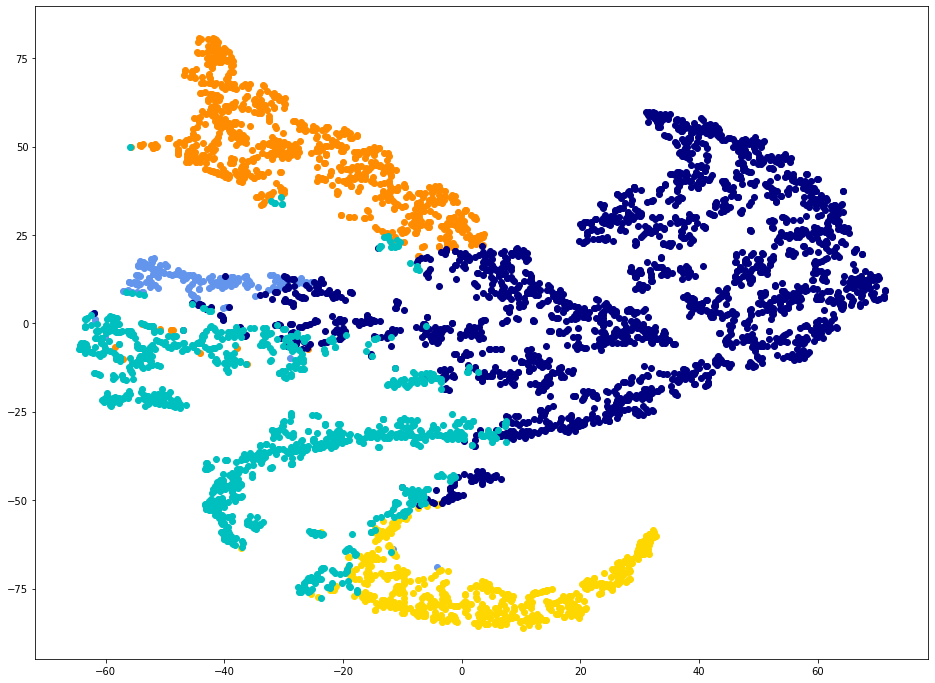

In [211]:
draw_clusters(clusters_spectral, cluster_num, embeddings_cosine, color_iter)

SpectralClustering doesn't look good, let's try dbscan

In [330]:
from sklearn.cluster import DBSCAN

def draw_clusters_with_outliners(clusters, cluster_num, embeddings, colors):
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(1, 1, 1)

    for g, c in zip(range(cluster_num), colors):
        condlist = clusters == g
        cluster = np.compress(condlist, embeddings, axis=0)

        x, y = cluster.transpose()

        ax.scatter(x, y, c=c)
    
    # outliners
    cs = clusters.tolist()
    cls_list = list(range(cluster_num))
    
    condlist = [True if c not in cls_list else False for c in cs]

    cluster = np.compress(condlist, embeddings, axis=0)
    
    x, y = cluster.transpose()
    ax.scatter(x, y, c='lightcoral')
    
    plt.show()

In [331]:
clusters_dbscan = DBSCAN(
    eps=0.07,
    min_samples=150,
    metric='cosine'
).fit_predict(embeddings)


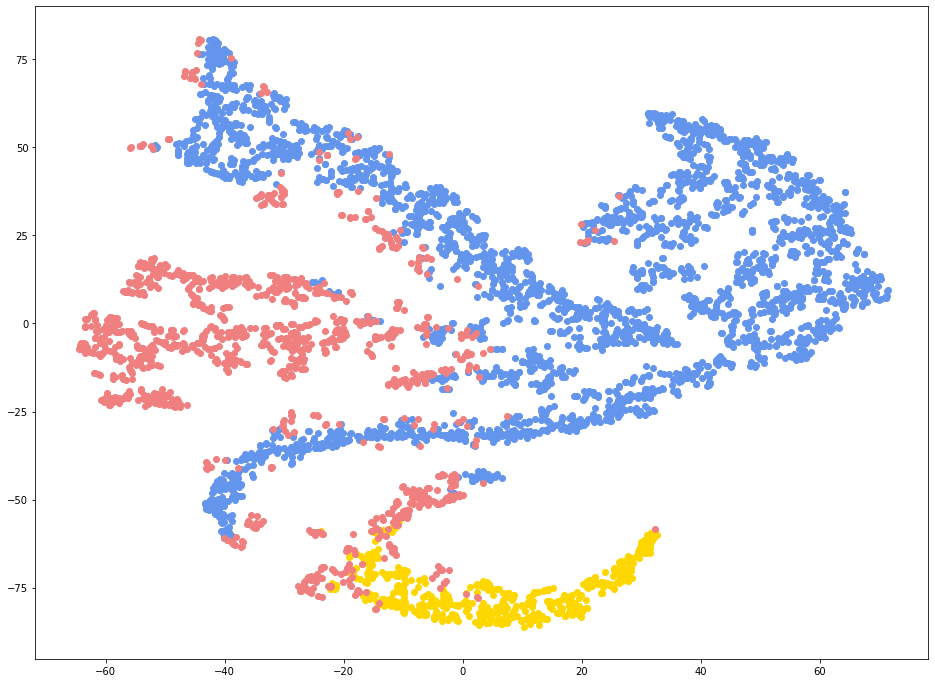

In [332]:
draw_clusters_with_outliners(clusters_dbscan, cluster_num, embeddings_cosine, color_iter)

dbscan doesn't look good...  

### now let's directly plot images to t-SNE space, and try to cluster by our eyes


In [365]:
# pick 1000 images

embed_vis = embeddings_cosine[:1000, ...]
clusters_vis = clusters_bgmm[:1000, ...]
filenames_vis = chunk_dataset.chunk_list[:1000]

In [13]:
PIC_SIZE = 6400

def draw_pics(embeddings, filenames):
    fig = plt.figure(figsize=(32,32))
    ax = fig.add_subplot(1, 1, 1)
    
    img = np.full((PIC_SIZE, PIC_SIZE, 3), 255)
    
    rois = []
    
    xs, ys = embeddings.transpose()
    x_max = np.max(xs)
    x_min = np.min(xs)
    y_max = np.max(ys)
    y_min = np.min(ys)
    x_range = x_max - x_min
    y_range = y_max - y_min
    
    for embedding, filename in zip(embeddings, filenames):
        roi_img = cv2.imread(filename)
        w, h, _ = roi_img.shape
        
        x = int(((embedding[0] - x_min) / x_range) * PIC_SIZE)
        y = int(((embedding[1] - y_min) / y_range) * PIC_SIZE)
        
        if (x+w <= PIC_SIZE) and (y+h <= PIC_SIZE):
            img[x:x+w, y:y+h, ...] = roi_img
            
    ax.imshow(img)
    plt.show()
    cv2.imwrite('pic.jpg', img)

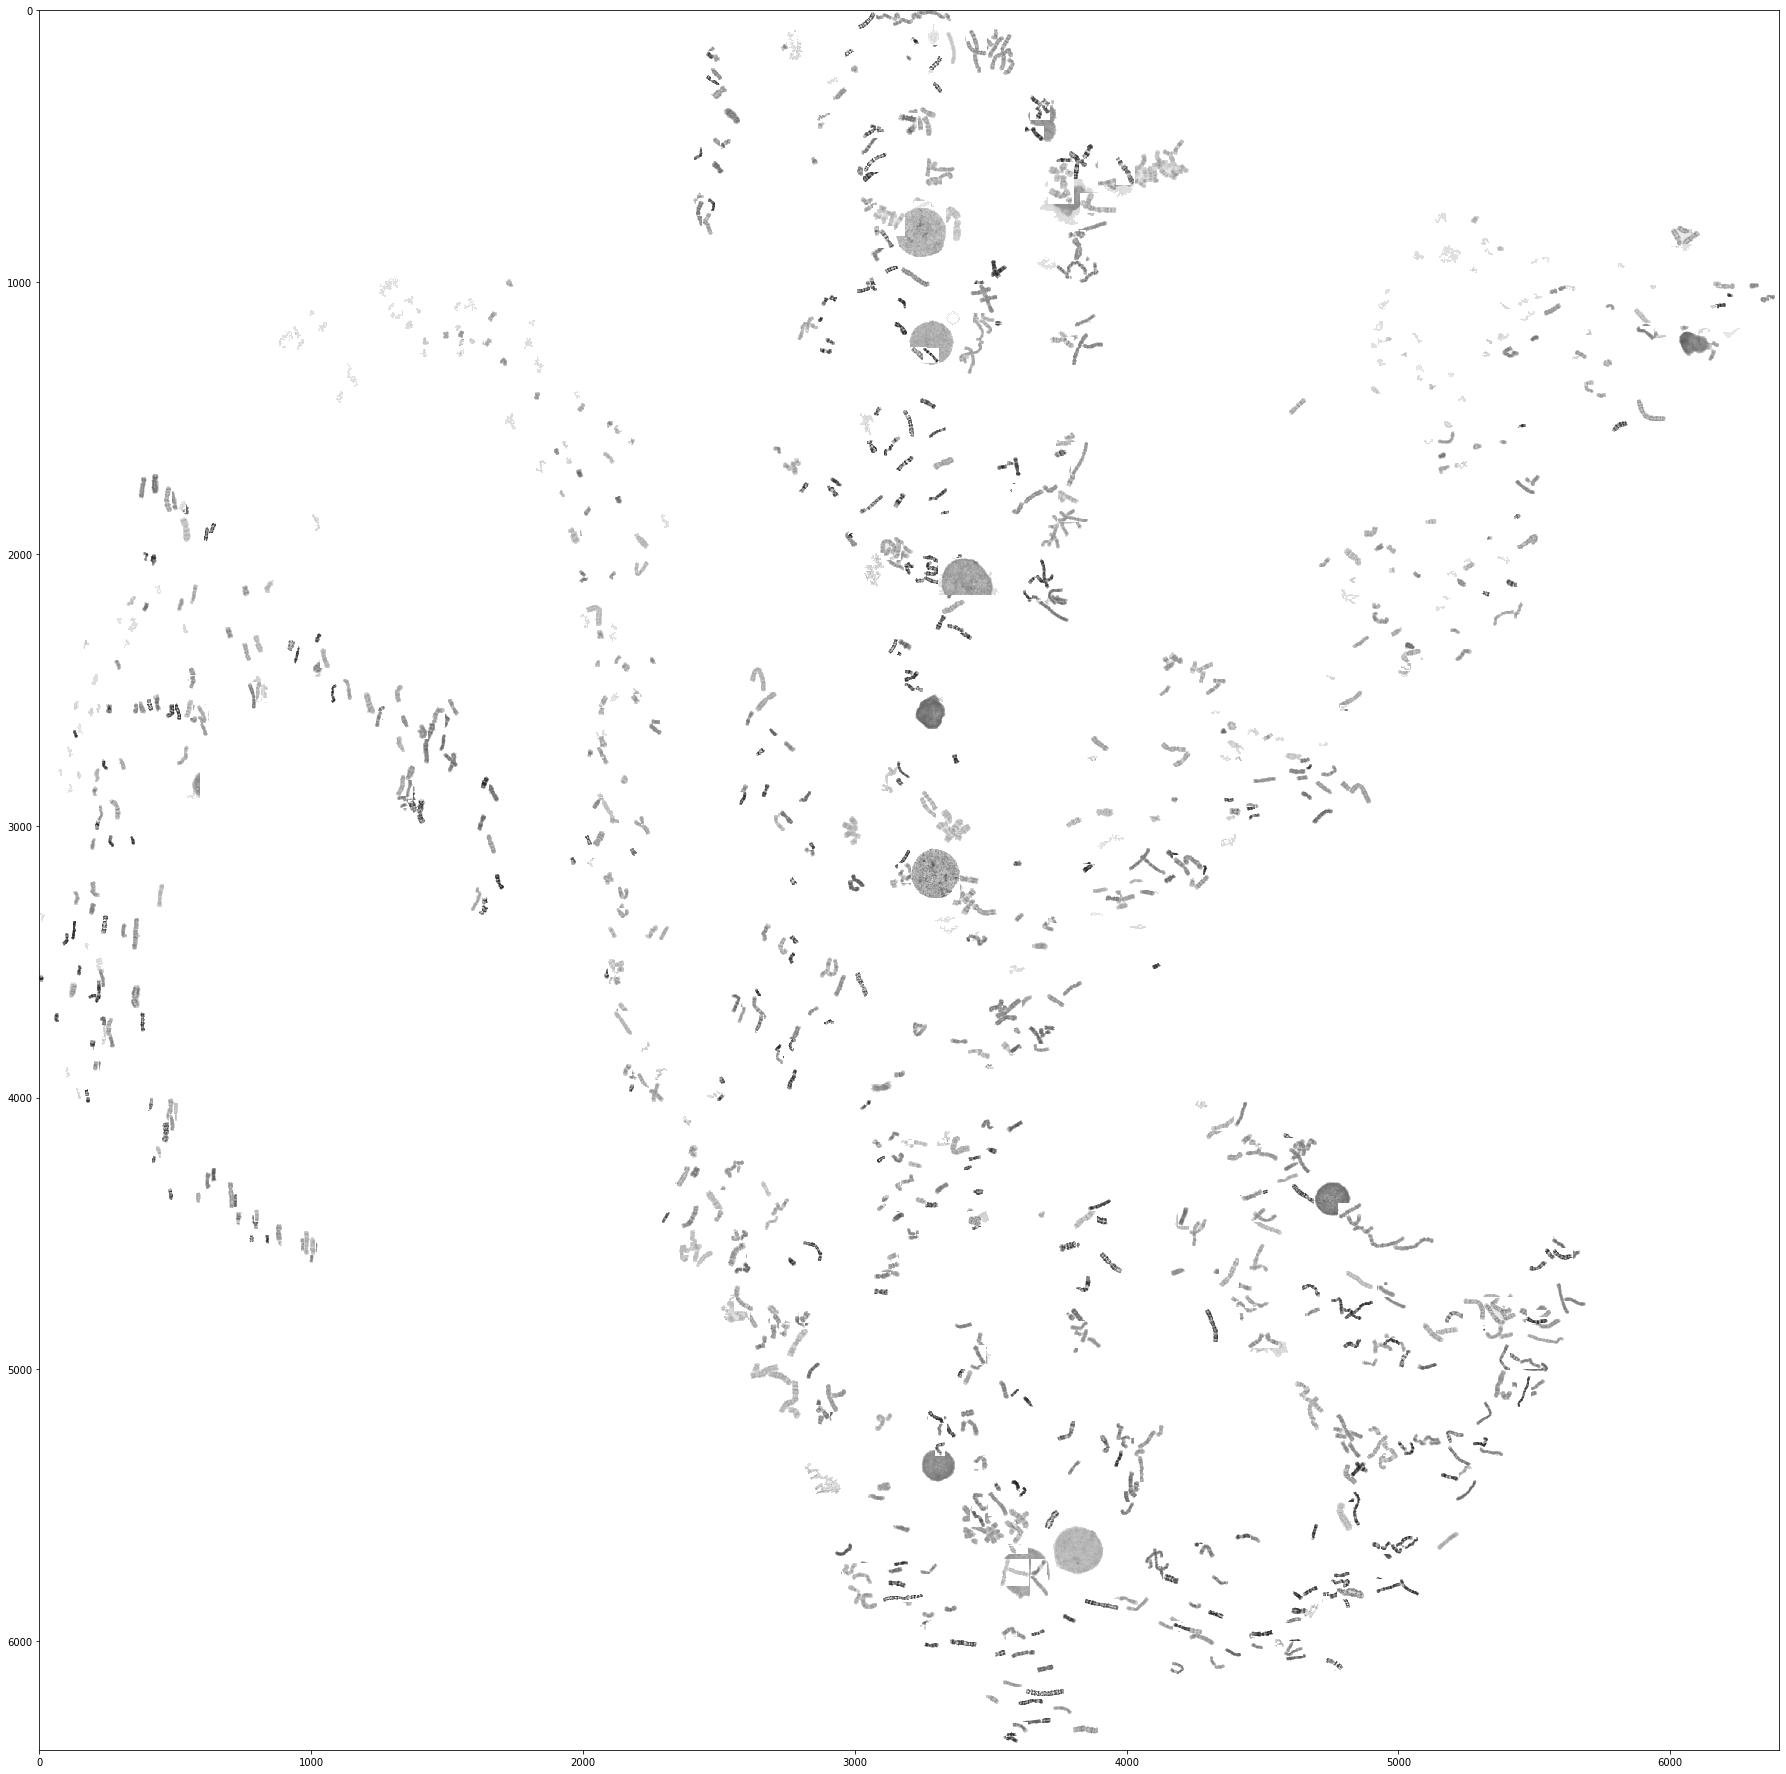

In [390]:
#draw_clusters(clusters_vis, cluster_num, embed_vis, color_iter)
draw_pics(embed_vis, filenames_vis)

## 6. PCA

Let's try PCA on the 1000-dim embeddings.  

In [6]:
from sklearn.decomposition import PCA

PCA_EMBEDDING_COUNT = 1000000
pca_embeddings = all_embeddings[:PCA_EMBEDDING_COUNT]

# clean up
del all_embeddings

gc.collect()
torch.cuda.empty_cache()


In [7]:
pca = PCA()
pca.fit(pca_embeddings)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

<BarContainer object of 18 artists>

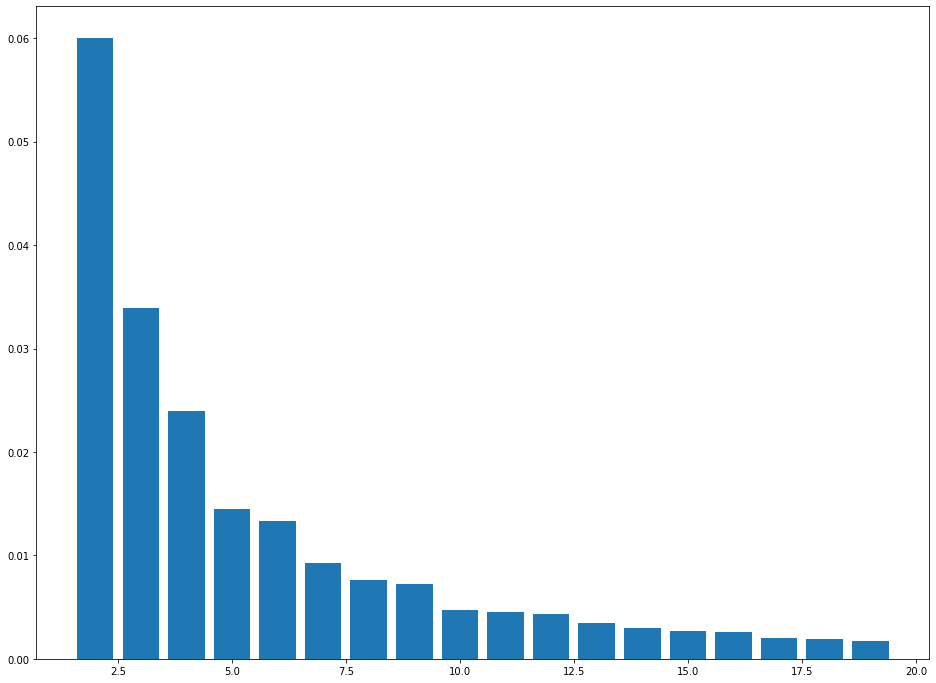

In [8]:
pca.explained_variance_ratio_

fig = plt.figure(figsize=(16,12))
plt.bar(range(2, 20), pca.explained_variance_ratio_[2:20])

In [9]:
# pick top-5 components (variance > 0.02)

pca = PCA(n_components=5)
pca_results = pca.fit_transform(pca_embeddings)


In [17]:
print(pca_results.shape)

(1000000, 5)


OK, t-SNE again

In [10]:
embeddings_pca_euc = TSNE(n_components=2).fit_transform(pca_results[:5000])

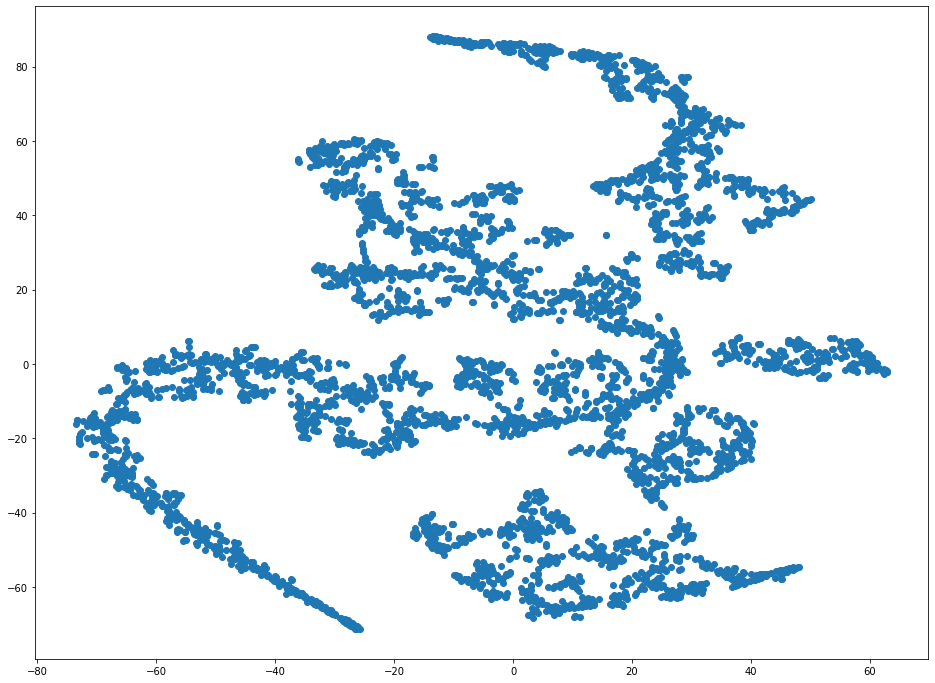

In [11]:
draw_tsne(embeddings_pca_euc)

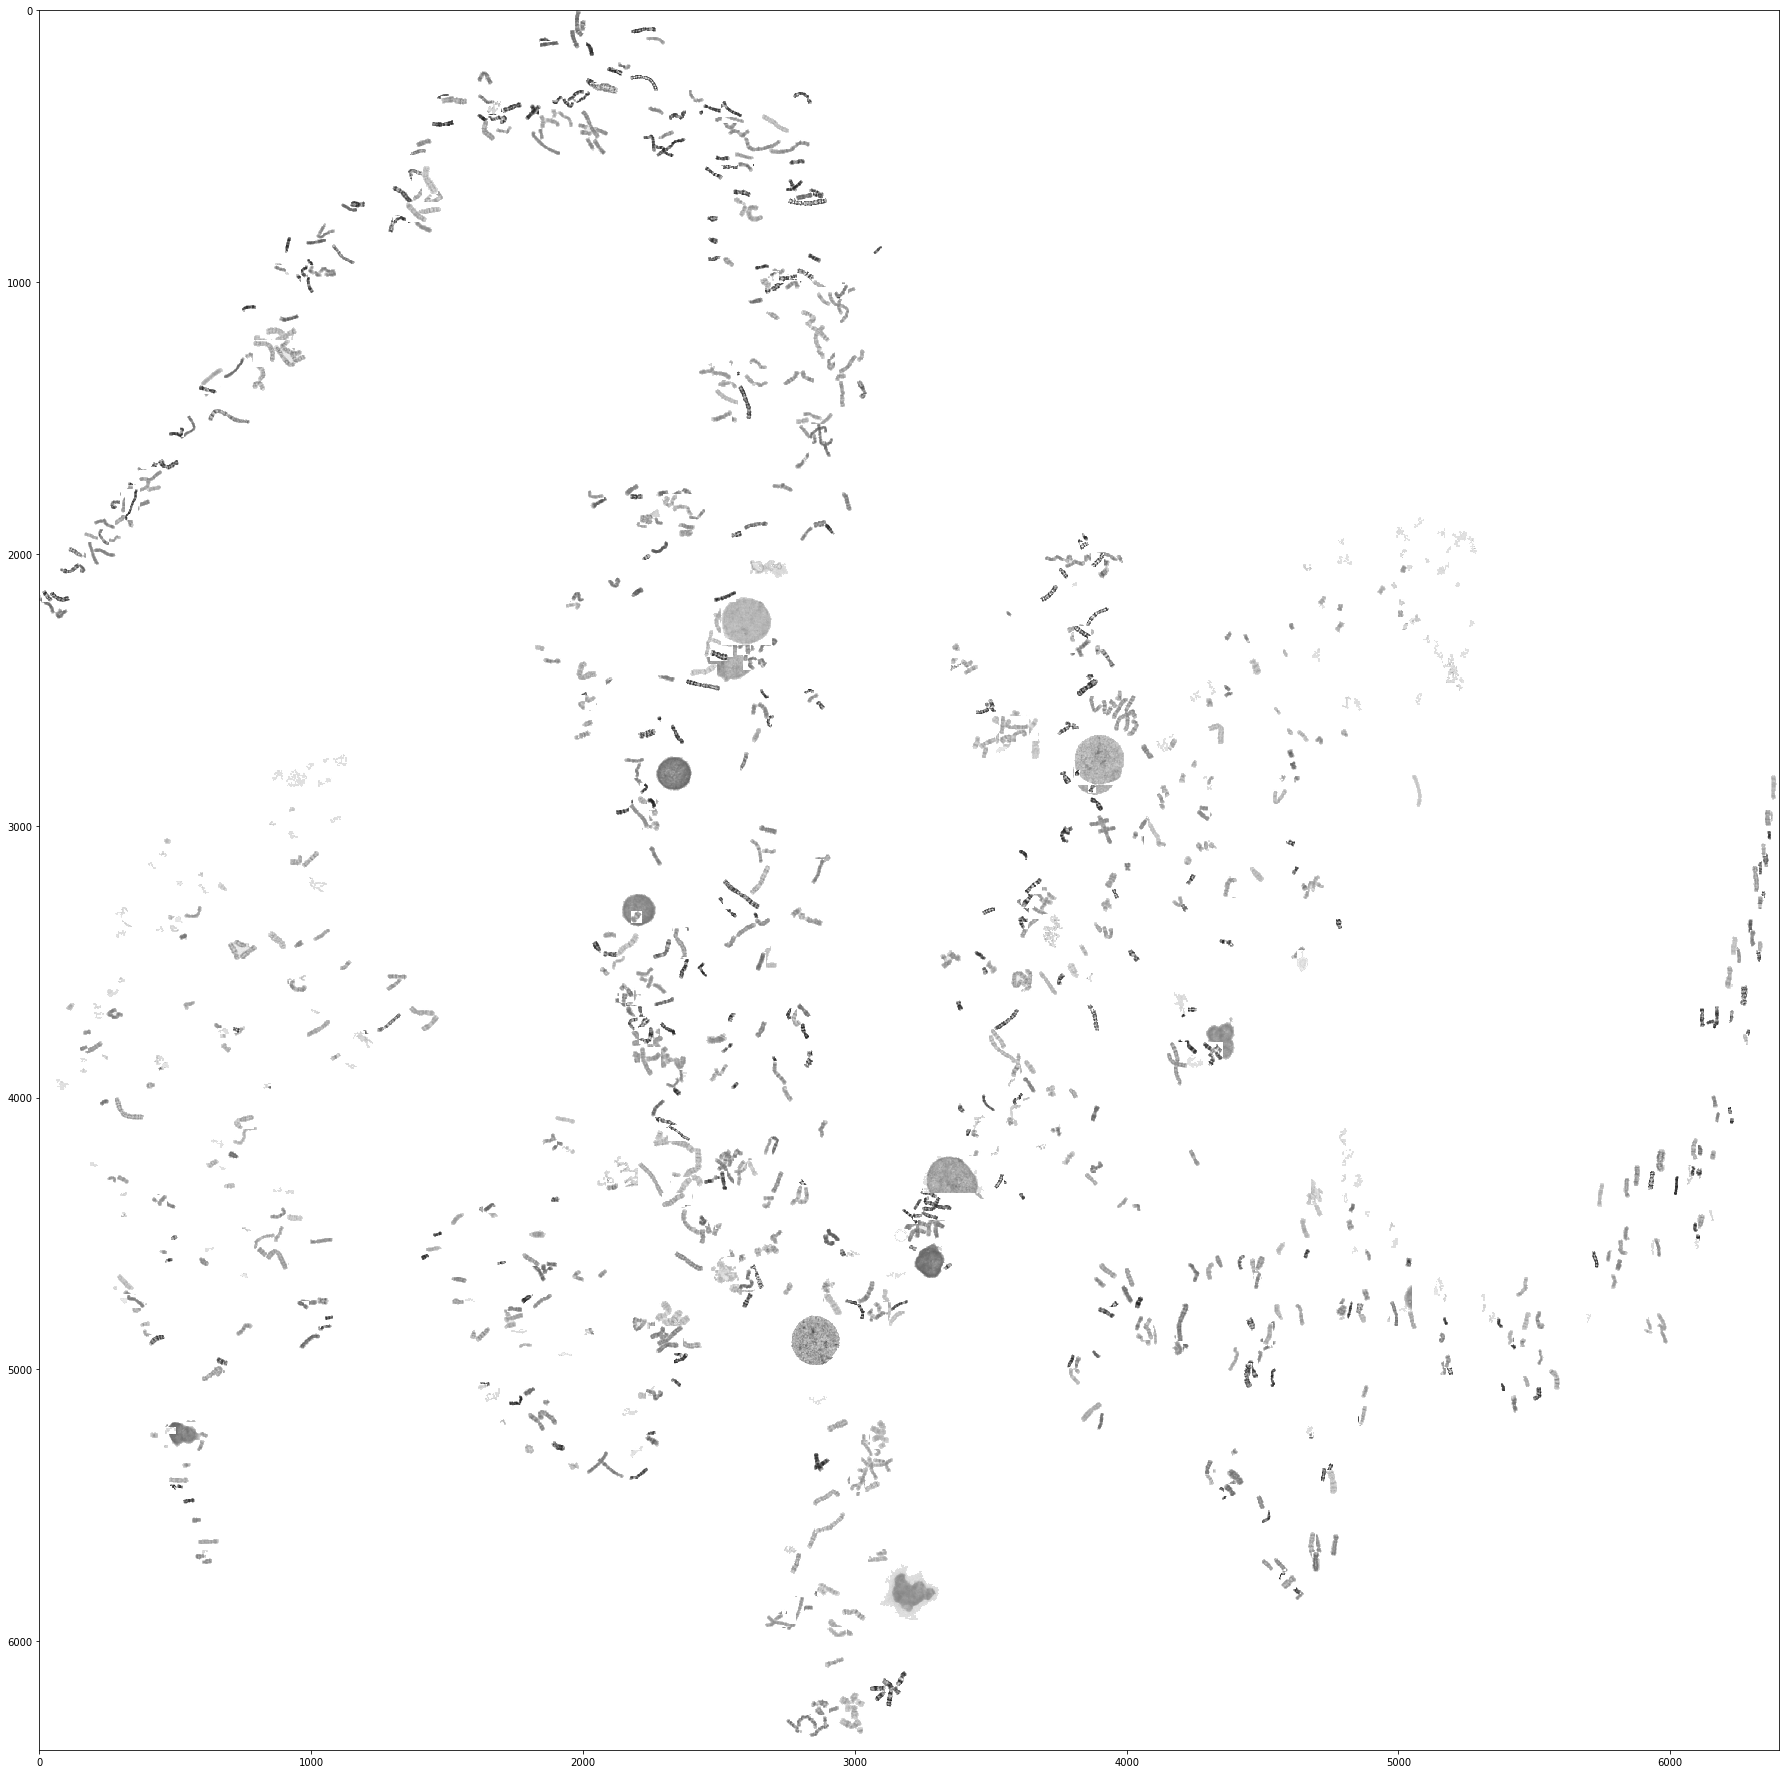

In [20]:
PCA_EUC_COUNT = 1000
draw_pics(embeddings_pca_euc[:PCA_EUC_COUNT], chunk_dataset.chunk_list[:PCA_EUC_COUNT])

Let's do something interesting, directly PCA to 2D:

In [21]:
pca = PCA(n_components=2)
pca_results_2d = pca.fit_transform(pca_embeddings)

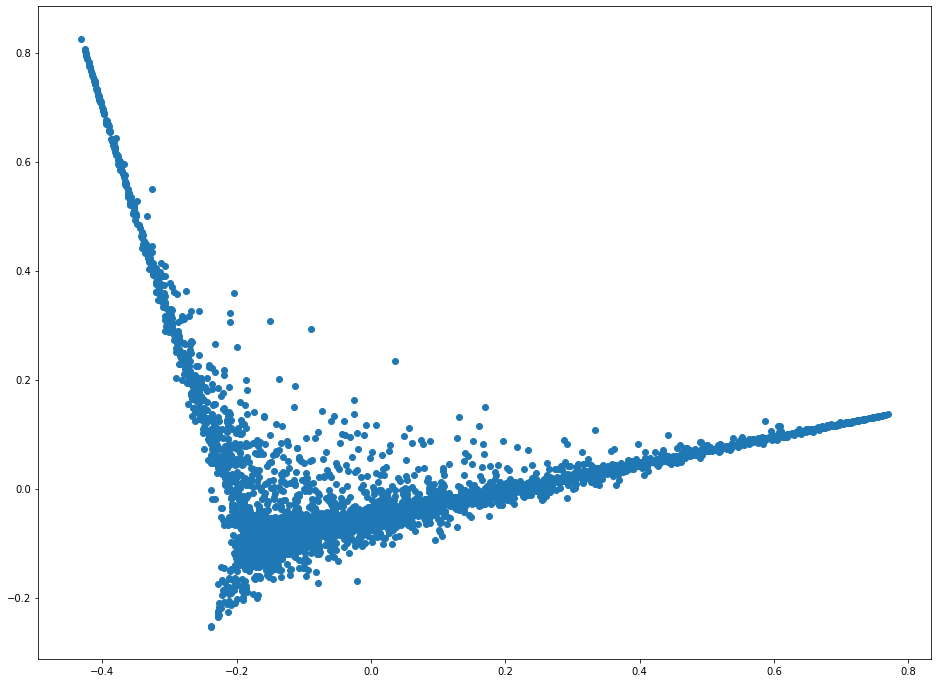

In [25]:
draw_tsne(pca_results_2d[:5000])

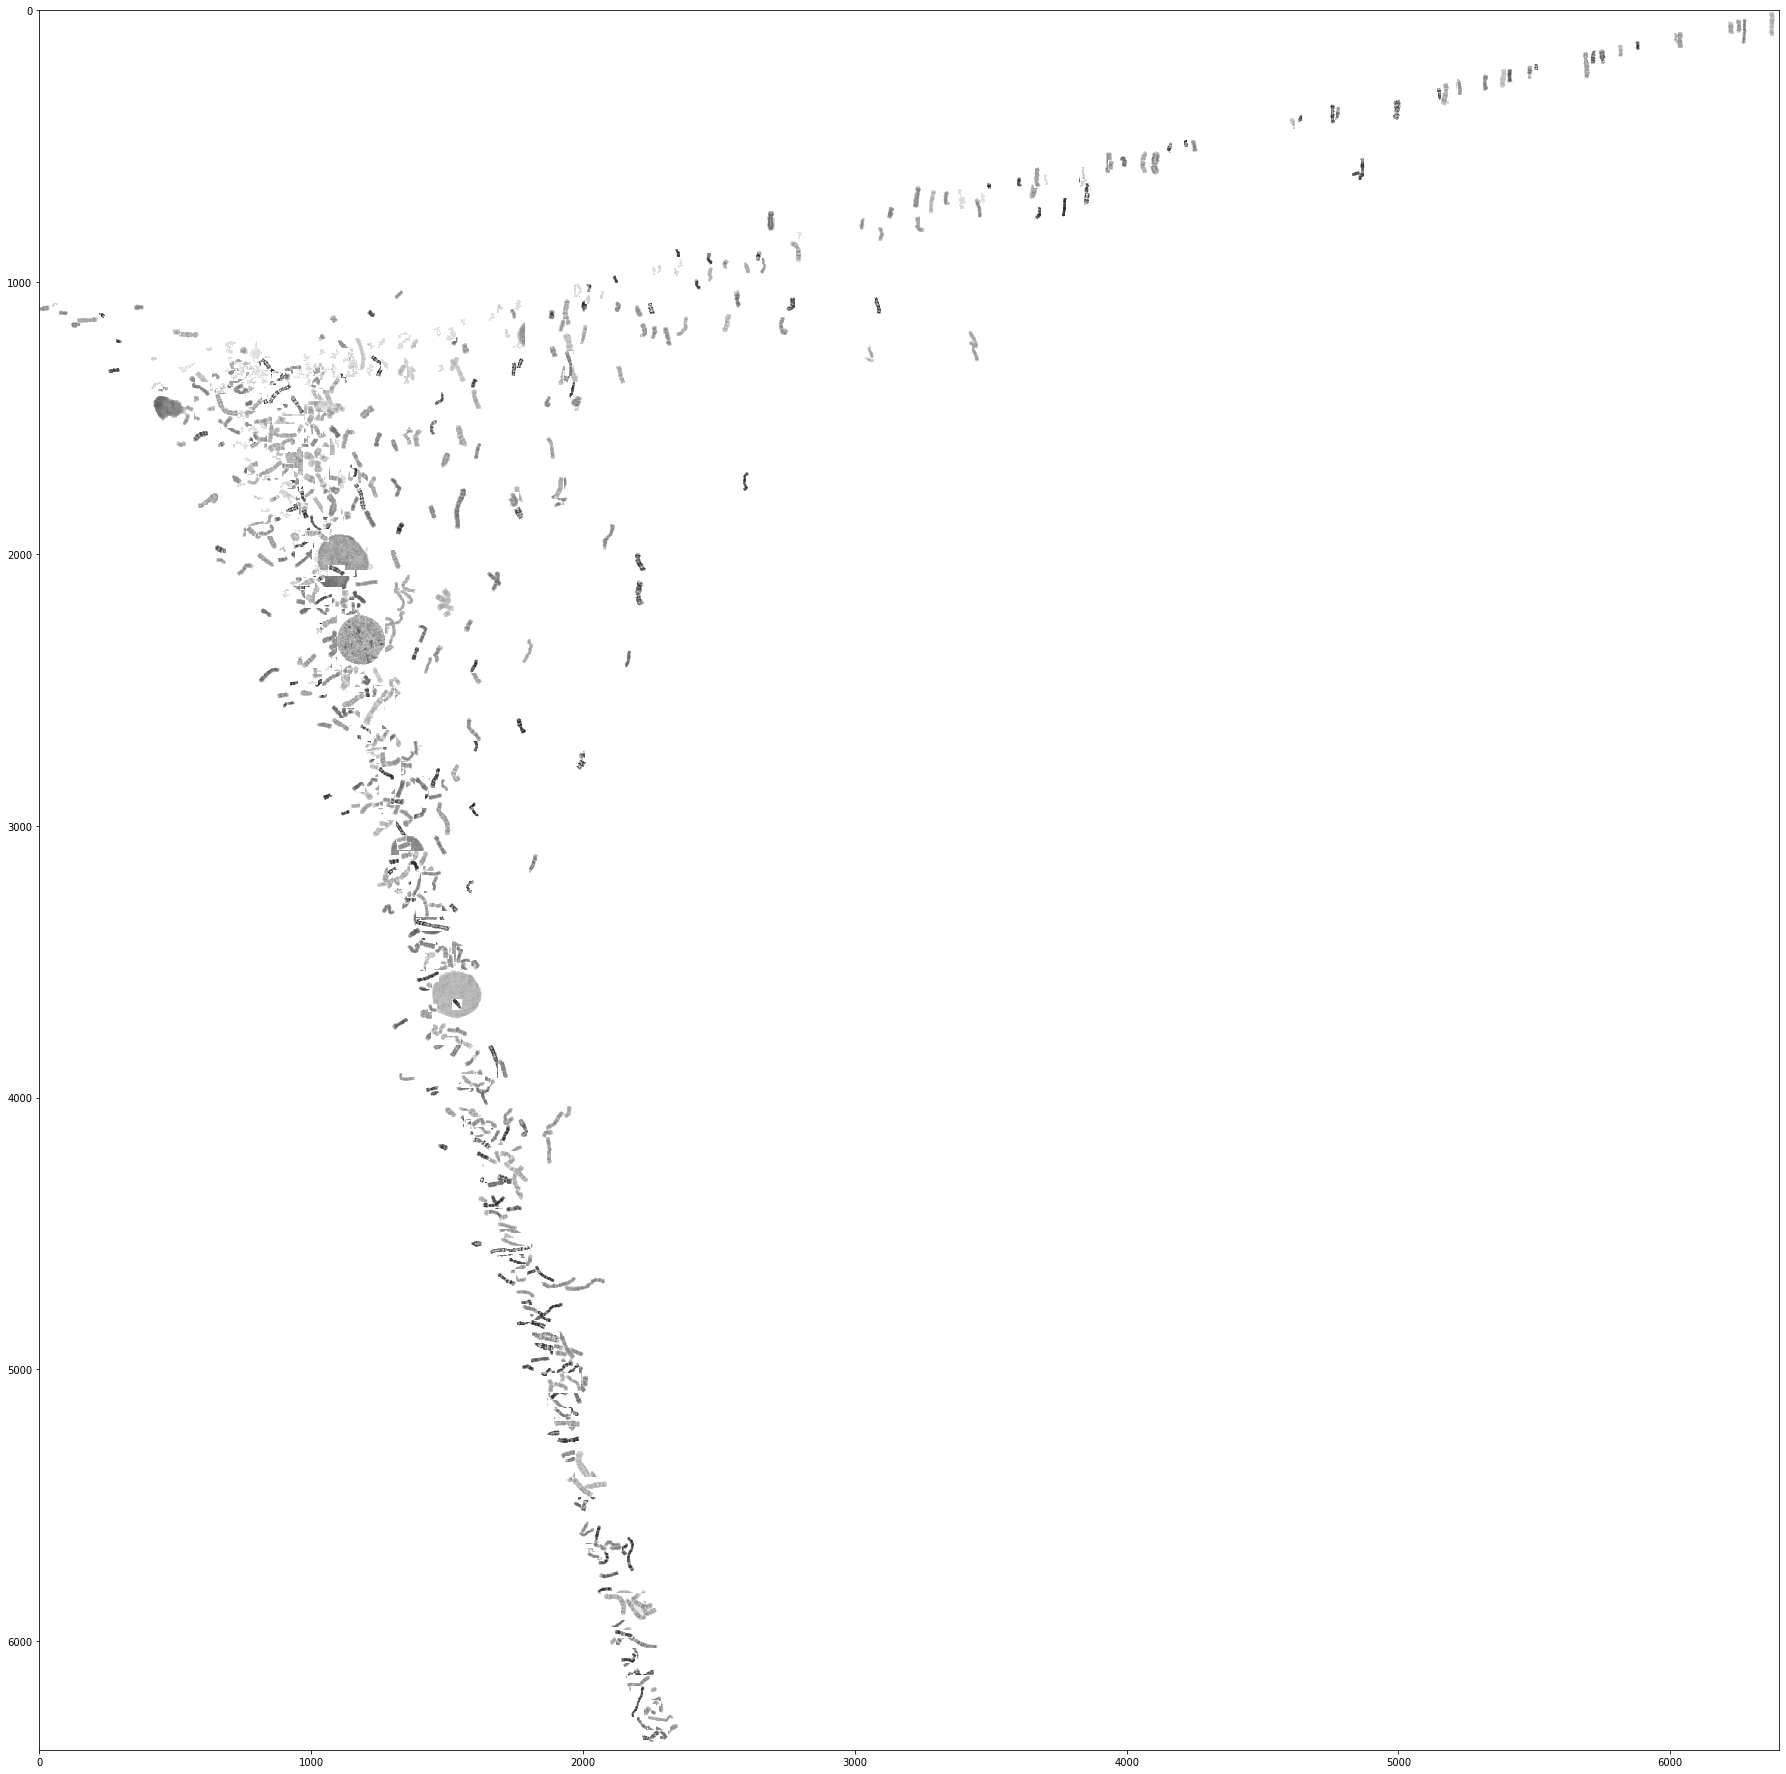

In [29]:
PCA_EUC_2D_COUNT = 1000
draw_pics(pca_results_2d[:PCA_EUC_2D_COUNT], chunk_dataset.chunk_list[:PCA_EUC_2D_COUNT])

In [22]:
embeddings_pca_euc_2d = TSNE(n_components=2).fit_transform(pca_results_2d[:5000])

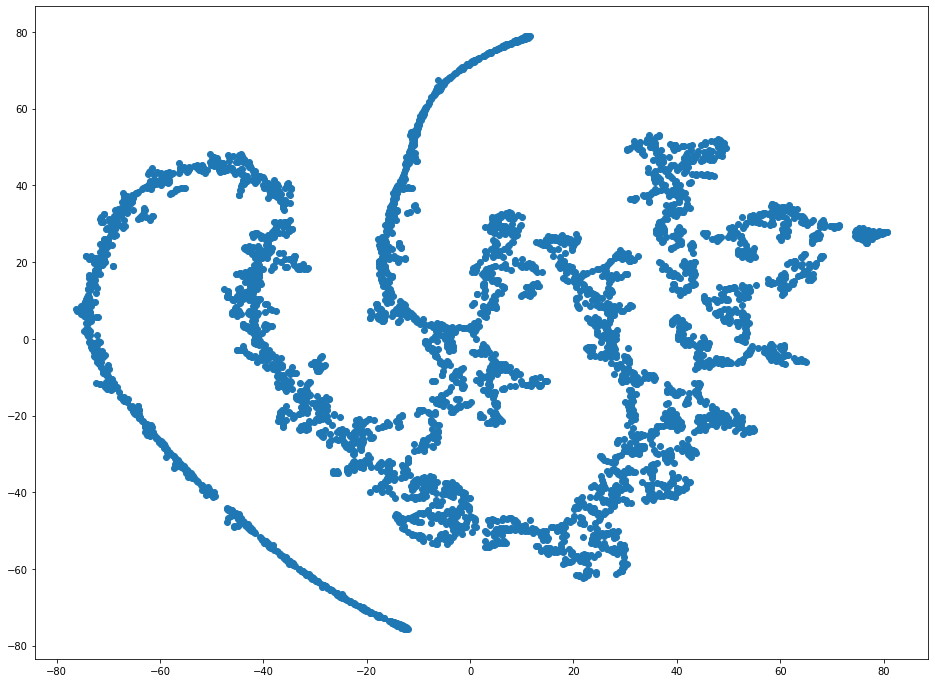

In [23]:
draw_tsne(embeddings_pca_euc_2d)

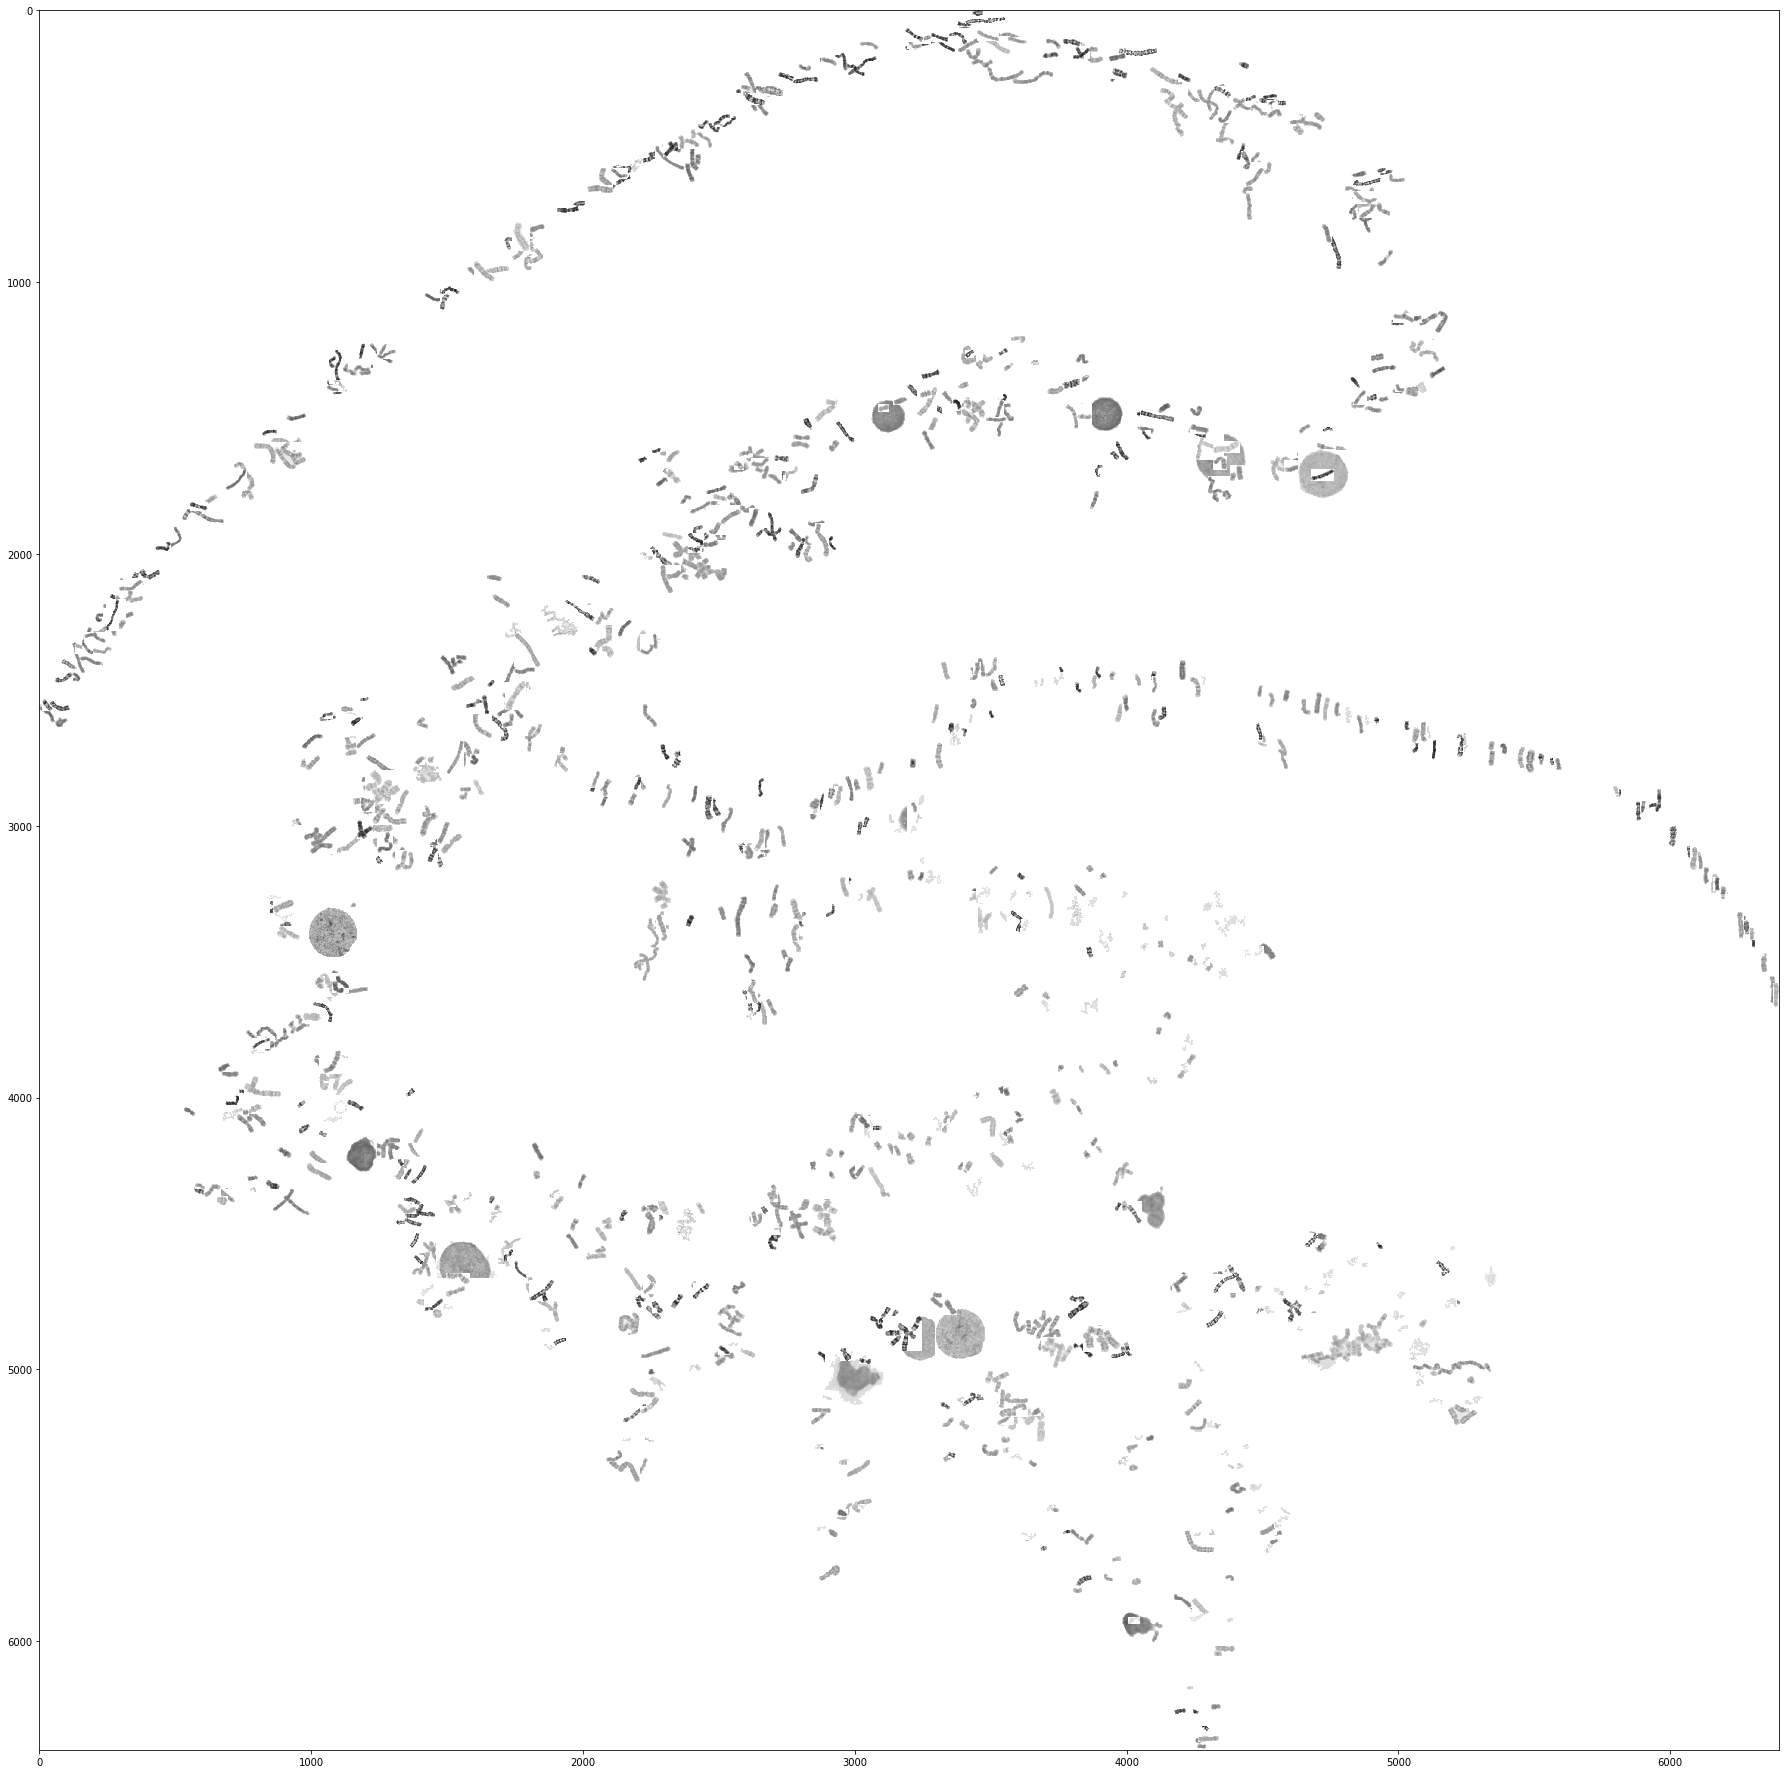

In [28]:
PCA_EUC_2D_COUNT = 1000
draw_pics(embeddings_pca_euc_2d[:PCA_EUC_2D_COUNT], chunk_dataset.chunk_list[:PCA_EUC_2D_COUNT])